In [1]:
import numpy as np
import random
import pandas as pd
import time
from matplotlib import pyplot as plt
import traceback
from IPython import display
from datetime import datetime, timedelta, time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
class EpsilonGreedyStrategy():
    def __init__(self, starting_eps, ending_eps, eps_decay):
        self.starting_eps = starting_eps
        self.ending_eps = ending_eps
        self.eps_decay = eps_decay
    
    def get_epsilon_rate(self, episode):
        epsilon_rate = self.ending_eps + (self.starting_eps - self.ending_eps) * np.exp(-self.eps_decay * episode)
        return epsilon_rate

In [4]:
class Space:
    balance_space = np.linspace(0, 1200, 121)
    position_space = np.linspace(0, 1200, 121)
    action_space = np.arange(-3, 4, 1)
    price_space = None 
    
    def __init__(self):
        pass
    


class State:
    def __init__(self, balance, position, prices, t, overnight_position_penalty, transaction_cost, min_cash_position):
        #assert isinstance(position, float)
        #assert isinstance(prices, list)
        #assert isinstance(t, int)
        #assert isinstance(balance, float)
        self._position = position
        self._balance = balance
        self._prices = prices
        self._t = t
        self._balance_space = Space.balance_space
        self._position_space = Space.position_space
        self._action_space = Space.action_space
        self._price_space = Space.price_space
        self._overnight_position_penalty = overnight_position_penalty
        self._transaction_cost = transaction_cost
        self._min_cash_position = min_cash_position
    
    def position(self):
        return self._position
    
    def balance(self):
        return self._balance
    
    def portfolio_value(self):
        return self._position + self._balance
    
    def prices(self, lag = 0):
        assert lag <= self._t, 'lag must be less than equal to t'
        return list(reversed(self._prices[self._t - lag: self._t + 1]))
    
    def price(self, t):
        return self._prices[t]

    def is_last_state(self):
      return self._t == len(self._prices) - 1
    
    def binned_state(self, lag = 0):
        binned_position = np.digitize(self.position(), self._position_space, right = True)
        binned_balance = np.digitize(self.balance(), self._balance_space, right = True)
        tmp = [binned_position, binned_balance]
        
        for i in range(lag+1):
            tmp.append(np.digitize(self.prices(lag)[i], self._price_space, right = True))
        return tmp
    
    def _adj_ation(self, action):
        max_shares_sell = self.position() // self.price(self._t)
        max_shares_sell = min(self.balance() // self._transaction_cost, max_shares_sell)
        max_shares_buy = (self.balance() - self._min_cash_position) // self.price(self._t)
        return max(action, -max_shares_sell) if action < 0 else min(action, max_shares_buy)


    def update_state(self, action):
        penalty = 0
        action = self._adj_ation(action)
        if self.is_last_state():
          r = 0
          if state.position() // state.price(self._t) + action != 0:
            penalty = 1
        else: 
          r = self.price(self._t+1)/self.price(self._t) - 1
        
        new_state = State(self._balance - action*self.price(self._t), (self._position + action*self.price(self._t)) * (1 + r) - abs(self._transaction_cost*action), self._prices, self._t + 1, self._overnight_position_penalty, self._transaction_cost, self._min_cash_position)
        reward = new_state.portfolio_value() - self.portfolio_value() + self._overnight_position_penalty*penalty
        return new_state, reward
    
    def __str__(self):
        return 'Balance: %.2f; Dollar Position: %.2f; Price %.2f; Time %d' % (self._balance, self._position, self._prices[self._t], self._t)

In [5]:
class Agent():
    def __init__(self, strategy, action_space, lag = 0):
        self.strategy = strategy
        self.action_space = action_space
        self._lag = lag
    
    def lag(self):
        return self._lag
        
    def action_sample(self):
         return random.choice(self.action_space)
    
    def choose_action(self, state, q_table, episode):
        epsilon_rate_threshold = np.random.uniform(0,1)
        epsilon_rate = self.strategy.get_epsilon_rate(episode)

        bs = state.binned_state(self._lag)
        bs_tuples = [tuple(bs + [a]) for a in range(7)]
        tmp_q = [q_table[tmp_bs] for tmp_bs in bs_tuples]
    
        if epsilon_rate_threshold > epsilon_rate:
            action = np.argmax(tmp_q) - 3
        else:
            action = self.action_sample()
        return action

In [6]:
def get_return_and_vol(ts):
  arr = np.zeros(len(ts)-1)
  for i in range(len(ts) - 1):
    arr[i] = ts[i + 1] / ts[i] - 1
  s = np.std(arr, ddof=1)
  r = ts[-1] / ts[0] - 1

  return r, s
  


In [19]:
def run_test(stock_prices,starting_eps,ending_eps,eps_decay, learning_rate, discount_rate,transaction_cost,max_num_steps_per_episode,max_num_episodes, starting_balance,min_cash_position,lags):
  Space.price_space = np.linspace(stock_prices.min()*.9, stock_prices.max()*1.1, 100)
  Strategy = EpsilonGreedyStrategy(starting_eps, ending_eps, eps_decay)
  agent = Agent(Strategy, Space.action_space, lags)
  spaces = [len(Space.position_space), len(Space.balance_space)]
  for i in range(agent.lag()+1):
      spaces.append(len(Space.price_space))
  spaces.append(len(Space.action_space))
  q_table = np.zeros(spaces)

  r_s = []

  for episode in range(max_num_episodes):
      state = State(starting_balance, 0, stock_prices, agent.lag(), overnight_position_penalty, transaction_cost, min_cash_position)
      values = np.zeros(max_num_steps_per_episode-agent.lag())
      values[0] = state.portfolio_value()
      for time_step in range(agent.lag(), max_num_steps_per_episode-1):
          action = agent.choose_action(state, q_table, episode)
          new_state, reward = state.update_state(action)
          
          # Update Q_table)
          bs = state.binned_state(agent.lag())
          bs_tuple = tuple(bs + [action+3])
          bs_tuples = [tuple(bs + [a]) for a in range(7)]
          tmp_q = [q_table[tmp_bs] for tmp_bs in bs_tuples]
          q_table[bs_tuple] = q_table[bs_tuple] * (1 - learning_rate) + \
              learning_rate * (reward + discount_rate * np.max(tmp_q))

          state = new_state
          values[time_step + 1 - agent.lag()] = state.portfolio_value()
      
      dat_r_s = get_return_and_vol(values)
      r_s.append((dat_r_s[0], dat_r_s[1], state.position()))

  return r_s
  

In [11]:
def run_scenario(file, name, result_list):
  df = pd.read_csv(file)
  df.drop("Unnamed: 0", axis=1, inplace=True)
  #stock_prices = df.iloc[3] # change index to select stock behavior
  stock_prices = df.values
  plt.subplot(1, 1, 1)
  plt.plot(stock_prices)
  plt.title('Stock Price vs Time')
  plt.show()
  r_s = run_test(stock_prices,starting_eps,ending_eps,eps_decay, learning_rate, discount_rate,transaction_cost,max_num_steps_per_episode,max_num_episodes, starting_balance, min_cash_position,lags)
  plt.subplot(2, 1, 1)
  plt.title('Return by episode')
  plt.plot([rs[0] for rs in r_s])
  plt.show()
  plt.subplot(3, 1, 1)
  plt.title('SD of Return by episode')
  plt.plot([rs[1] for rs in r_s])
  plt.show()
  base_r_s = get_return_and_vol(stock_prices)
  row = [name,base_r_s[0],base_r_s[1],0 if base_r_s[1] == 0 else base_r_s[0] / base_r_s[1], r_s[-1][0], r_s[-1][1],0 if r_s[-1][1] == 0 else r_s[-1][0] / r_s[-1][1], r_s[-1][2]]
  result_list.append(row)

NameError: name 'result_list' is not defined

No Drift Low Vol 0


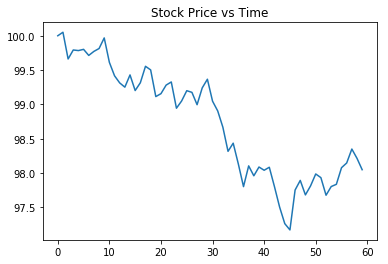

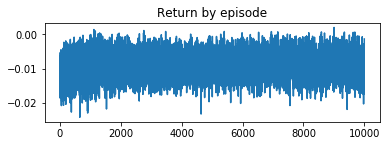

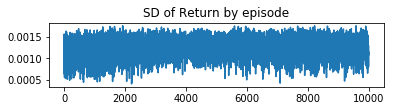

No Drift Low Vol 1


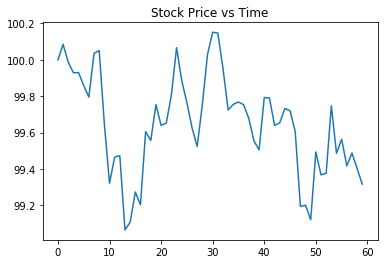

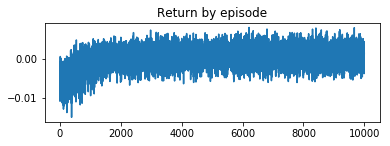

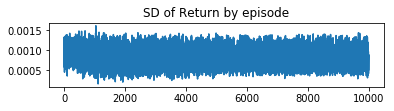

No Drift Low Vol 2


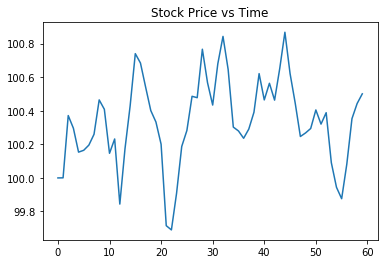

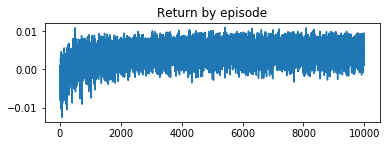

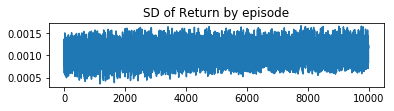

No Drift Low Vol 3


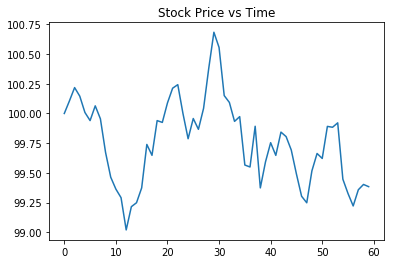

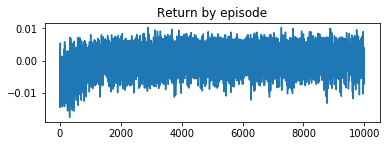

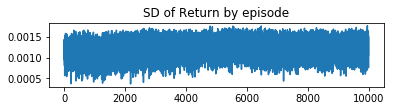

No Drift Low Vol 4


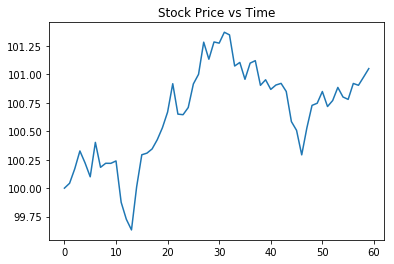

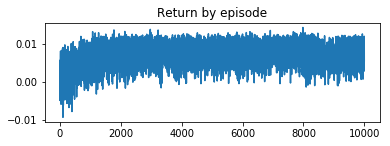

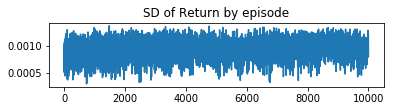

No Drift High Vol 0


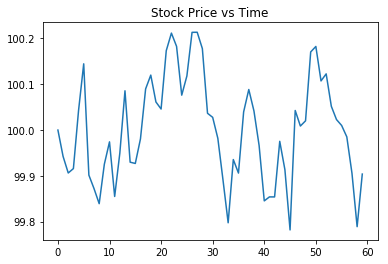

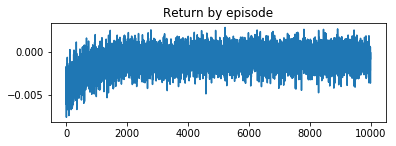

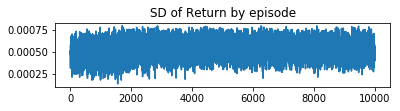

No Drift High Vol 1


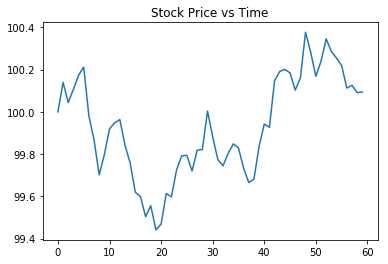

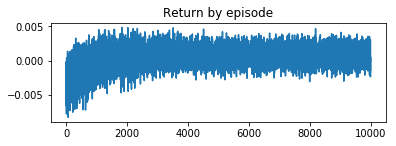

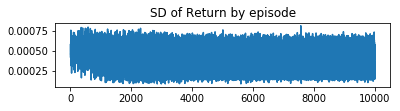

No Drift High Vol 2


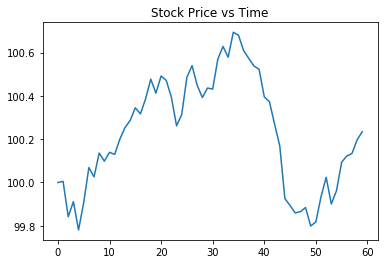

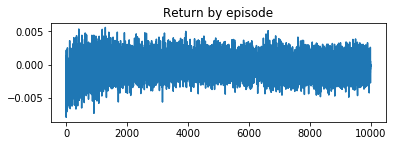

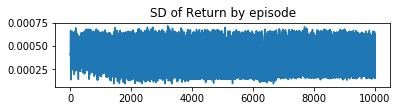

No Drift High Vol 3


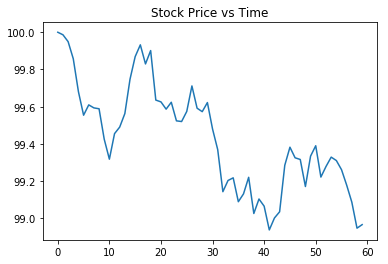

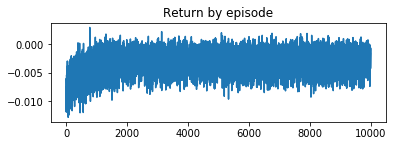

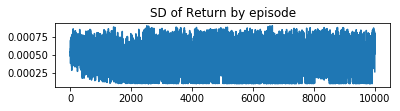

No Drift High Vol 4


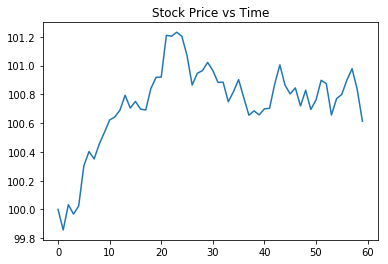

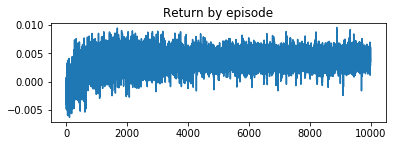

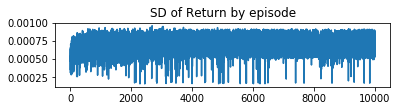

Positive Drift 0


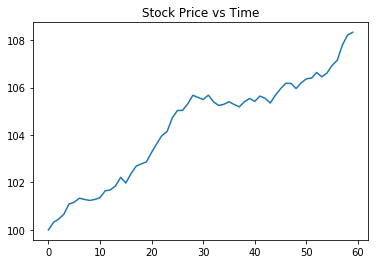

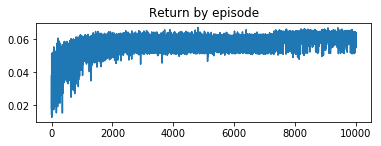

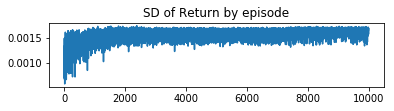

Positive Drift 1


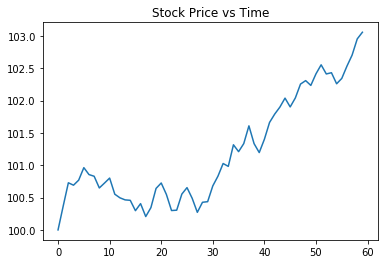

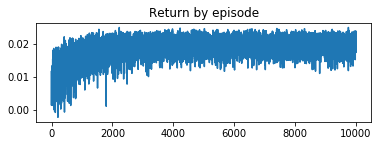

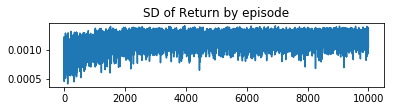

Positive Drift 2


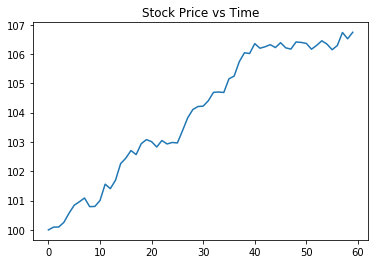

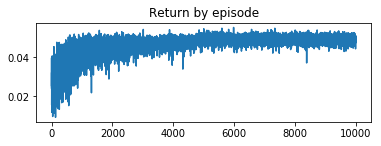

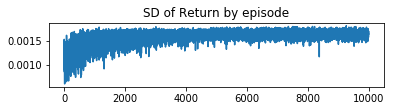

Positive Drift 3


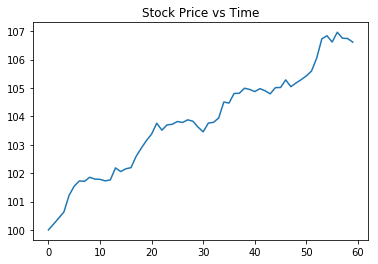

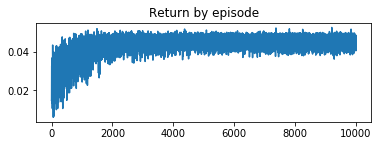

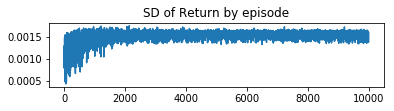

Positive Drift 4


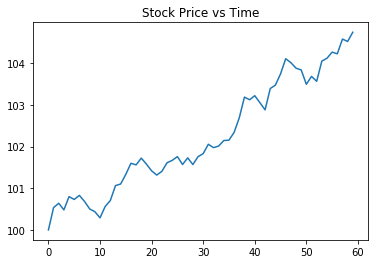

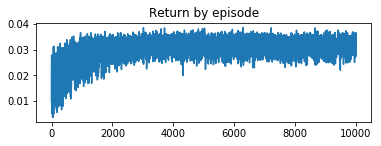

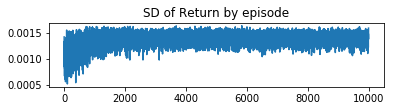

Negative Drift 0


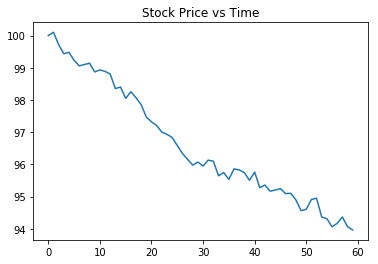

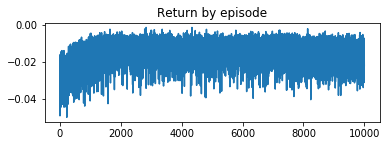

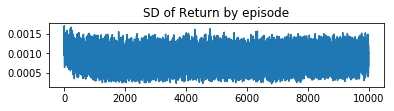

Negative Drift 1


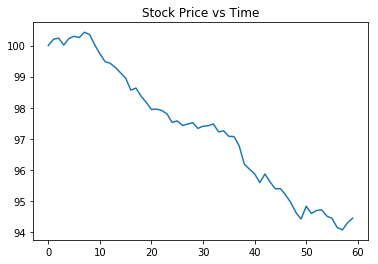

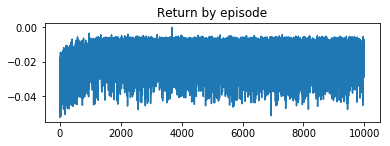

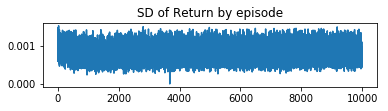

Negative Drift 2


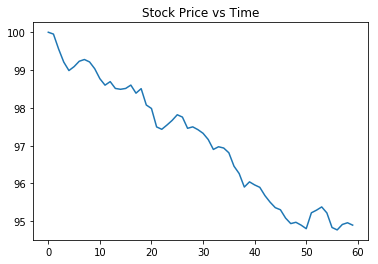

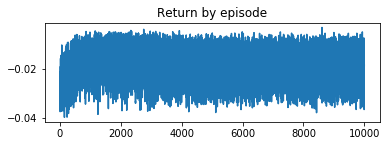

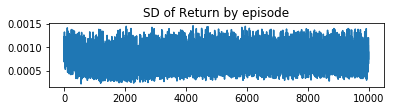

Negative Drift 3


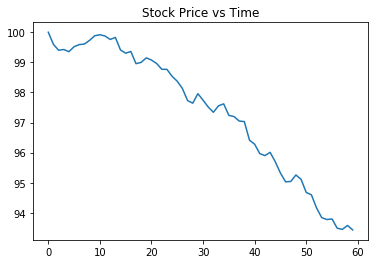

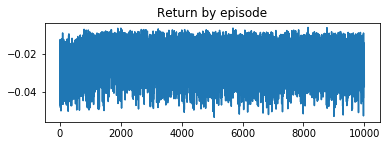

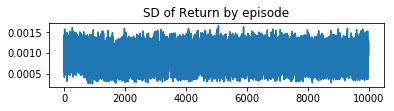

Negative Drift 4


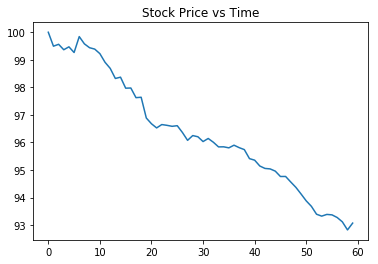

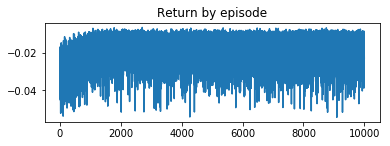

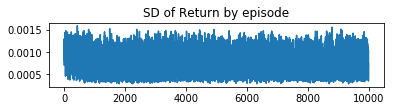

In [24]:
#Set Variables


starting_balance = 1000
max_num_episodes = 10000
max_num_steps_per_episode = 60
lags = 1
overnight_position_penalty = starting_balance*.10
min_cash_position = 50

transaction_cost = 0.05 #5 cents per share

starting_eps = 1
ending_eps = 0.01
eps_decay = 0.001

learning_rate = 0.01
discount_rate = 0.99

result_list = []
for file_name, name in [('nodr_lowvol_','No Drift Low Vol'), ('nodr_highvol_','No Drift High Vol'),('posdrift_','Positive Drift'),('negdrift_','Negative Drift')]:
  for i in range(5):
    print('%s %d' % (name,i))
    run_scenario("data/%s%d.csv" % (file_name,i), '%s %d' % (name,i), result_list)

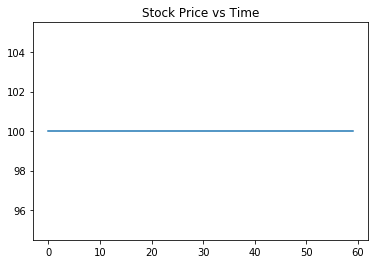

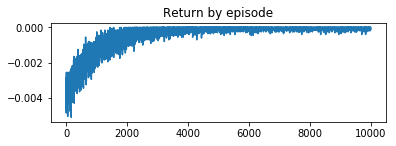

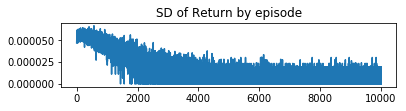

In [25]:
run_scenario("data/flat.csv", 'Flat', result_list)

In [26]:
result_df = pd.DataFrame(result_list,columns = ['Scenario','Base Return', 'Base SD','Base r/s','RL Return', 'RL SD','RL r/s', 'RL Overnight Position'])

In [27]:
result_df

,Scenario,Base Return,Base SD,Base r/s,RL Return,RL SD,RL r/s,RL Overnight Position
0,No Drift Low Vol 0,[-0.019511266462498567],0.002110,[-9.247277661000478],-0.001297,0.000830,-1.563473,[94.72058754802458]
1,No Drift Low Vol 1,[-0.006838374338332787],0.001829,[-3.739018373813462],0.001409,0.000888,1.586316,[493.53933167440096]
2,No Drift Low Vol 2,[0.005009768892116462],0.001925,[2.6026712793180082],0.005420,0.001212,4.474056,[800.8032988456724]
3,No Drift Low Vol 3,[-0.006156976602252895],0.002042,[-3.0153249243149105],-0.000058,0.001054,-0.055214,[791.7874899766632]
4,No Drift Low Vol 4,[0.010497564785015179],0.001555,[6.750224700820513],0.005589,0.001213,4.606715,[603.3848108348466]
5,No Drift High Vol 0,[-0.0009608690098257266],0.000933,[-1.0296492825632197],-0.000787,0.000427,-1.841542,[497.2713620567958]
6,No Drift High Vol 1,[0.0009372303712023022],0.000986,[0.9508430703656027],-0.001348,0.000363,-3.717613,[499.0152557255104]
7,No Drift High Vol 2,[0.0023461967553419782],0.000863,[2.719186110034708],-0.000243,0.000534,-0.455037,[899.5642969972512]
8,No Drift High Vol 3,[-0.010339545986351228],0.001086,[-9.524155884447529],-0.000666,0.000268,-2.485742,[97.52301408416201]
9,No Drift High Vol 4,[0.006135720785297449],0.001122,[5.468231238930209],0.003616,0.000601,6.011361,[500.3235888044269]


In [28]:
result_df[result_df['RL r/s'] > result_df['Base r/s']]


,Scenario,Base Return,Base SD,Base r/s,RL Return,RL SD,RL r/s,RL Overnight Position
0,No Drift Low Vol 0,[-0.019511266462498567],0.002110,[-9.247277661000478],-0.001297,0.000830,-1.563473,[94.72058754802458]
1,No Drift Low Vol 1,[-0.006838374338332787],0.001829,[-3.739018373813462],0.001409,0.000888,1.586316,[493.53933167440096]
2,No Drift Low Vol 2,[0.005009768892116462],0.001925,[2.6026712793180082],0.005420,0.001212,4.474056,[800.8032988456724]
3,No Drift Low Vol 3,[-0.006156976602252895],0.002042,[-3.0153249243149105],-0.000058,0.001054,-0.055214,[791.7874899766632]
8,No Drift High Vol 3,[-0.010339545986351228],0.001086,[-9.524155884447529],-0.000666,0.000268,-2.485742,[97.52301408416201]
9,No Drift High Vol 4,[0.006135720785297449],0.001122,[5.468231238930209],0.003616,0.000601,6.011361,[500.3235888044269]
15,Negative Drift 0,[-0.06035941739872219],0.002089,[-28.89714627051909],-0.022113,0.000925,-23.897623,[748.184273077538]
16,Negative Drift 1,[-0.0555426634555769],0.001919,[-28.9431935644222],-0.010139,0.000569,-17.829350,[563.4541816185182]
17,Negative Drift 2,[-0.05101851131213209],0.001802,[-28.31741115734946],-0.018426,0.000899,-20.494051,[755.865244869418]
18,Negative Drift 3,[-0.06568809110183293],0.002045,[-32.12328350931154],-0.037123,0.001310,-28.329423,[838.4200745259537]
